# Step 3.2: Bayesian Poisson Model for Goals

## Overview
This notebook implements a **hierarchical Bayesian Poisson regression** model for predicting player goal counts.

**Model Type**: Poisson count regression (goals as counts: 0, 1, 2, ...)
**Target**: ECE ≤ 0.05, with full uncertainty quantification
**Structure**: Hierarchical position effects with domain-informed priors

**Expected Runtime**: 10-30 minutes for MCMC

## Cell 1: Setup & Imports

In [62]:
import sys
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
from sqlalchemy import create_engine
from src.models import bayesian_goals as bg
importlib.reload(bg)

from src.models.bayesian_goals import (
    load_data,
    build_model,
    prior_predictive_check,
    fit_model,
    check_convergence,
    posterior_predictive_check,
    predict_counts,
    predict_prob_score,
    evaluate_calibration,
    plot_posterior,
    plot_calibration_curve,
    save_model
)

# Set random seed
np.random.seed(42)

print("="*60)
print("STEP 3.2: BAYESIAN POISSON MODEL FOR GOALS")
print("="*60)

STEP 3.2: BAYESIAN POISSON MODEL FOR GOALS


## Cell 2: Load Data with Time-Split

In [63]:
print("\n[1/9] Loading data...")
df = load_data()

# Convert match_date to pandas Timestamp if it's not already
df['match_date'] = pd.to_datetime(df['match_date'])

print(f"  Total records: {len(df)}")
print(f"  Date range: {df['match_date'].min()} to {df['match_date'].max()}")
print(f"  Positions: {df['position'].value_counts().to_dict()}")

print(f"\n  Goals distribution:")
print(df['goals'].value_counts().sort_index())

print(f"\n  Goals statistics:")
print(f"  - Mean: {df['goals'].mean():.3f}")
print(f"  - Variance: {df['goals'].var():.3f}")
print(f"  - Overdispersion: {df['goals'].var() / df['goals'].mean():.3f}")

# Time-based split - use pd.Timestamp for comparison
split_date = pd.Timestamp('2018-07-05')
train_df = df[df['match_date'] < split_date].copy()
test_df = df[df['match_date'] >= split_date].copy()

print(f"\n  Train: {len(train_df)} samples ({train_df['goals'].mean():.3f} avg goals)")
print(f"  Test:  {len(test_df)} samples ({test_df['goals'].mean():.3f} avg goals)")


[1/9] Loading data...
Loaded 1720 records (dropped 0 with missing values)
  Total records: 1720
  Date range: 2018-06-14 00:00:00 to 2018-07-15 00:00:00
  Positions: {'Forward': 628, 'Defender': 512, 'Midfielder': 463, 'Goalkeeper': 117}

  Goals distribution:
goals
0    1579
1     129
2      10
3       2
Name: count, dtype: int64

  Goals statistics:
  - Mean: 0.090
  - Variance: 0.101
  - Overdispersion: 1.117

  Train: 1528 samples (0.090 avg goals)
  Test:  192 samples (0.089 avg goals)


## Cell 3: Prior Predictive Check


[2/9] Running prior predictive check...
PRIOR PREDICTIVE CHECK - GATE 1

This is a MANDATORY checkpoint in the Bayesian workflow.
We check if priors encode reasonable beliefs BEFORE seeing data.


BUILDING ROBUST HIERARCHICAL POISSON MODEL

Data Summary:
  Observations: 1528
  Positions: 4 ['Defender', 'Forward', 'Goalkeeper', 'Midfielder']
  Opponents: 32
  Features: 5
  Mean goals: 0.090
  Log(mean goals): -2.299

ROBUST PRIOR SPECIFICATION

1. Hyperprior Mean:
   μ_α ~ Normal(-2.299, 0.15)

2. Position Variation (TRUNCATED):
   σ_α ~ TruncatedNormal(0, 0.12, upper=0.25)
   → Prevents extreme position differences
   → Max multiplicative effect: exp(0.25) = 1.28x

3. Opponent Effects (TIGHTENED):
   γ_opponent ~ Normal(0, 0.10)
   → 95% of opponents within exp(±0.20) = [0.82, 1.22]

4. Feature Coefficients (MUCH TIGHTER):
   β ~ Normal(0, 0.25) for each feature
   → 1-SD change in feature → exp(0.25) = 1.28x effect
   → 2-SD change → exp(0.50) = 1.65x effect
   → Prevents extreme cum

Sampling: [alpha_position, beta, gamma_opponent, goals_obs, mu_alpha, sigma_alpha]


    ✓ No extreme lambda values (all < 10)


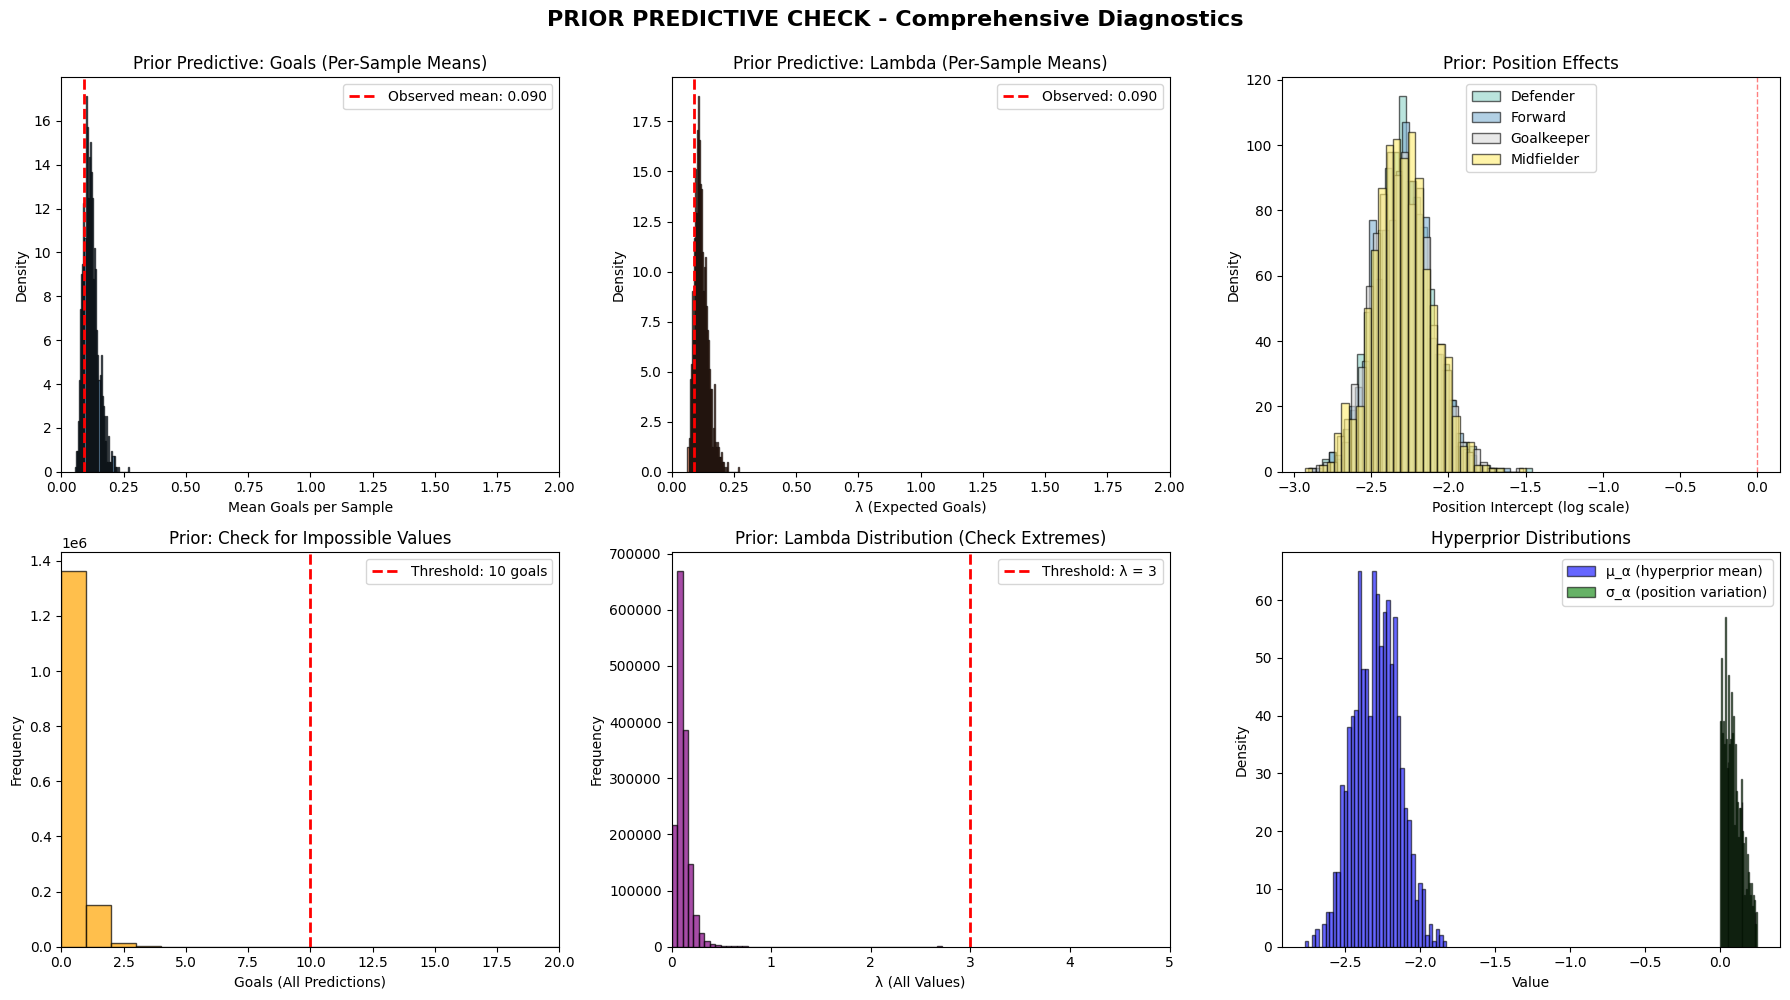


PRIOR PREDICTIVE CHECK - QUANTITATIVE RESULTS

1. CENTRAL TENDENCY (per-sample means):
   Prior goals: mean=0.118, median=0.115
   Prior lambda: mean=0.118, median=0.113
   Observed mean: 0.090
   → Difference: 0.028

2. SPREAD:
   Prior goals std: 0.029
   Prior lambda std: 0.028

3. CREDIBLE INTERVALS (per-sample):
   Goals 95% CI: [0.073, 0.187]
   Lambda 95% CI: [0.076, 0.186]

4. EXTREME VALUES CHECK (all predictions):
   ≤2 goals: 99.9%
   ≤5 goals: 100.0%
   >10 goals (impossible): 0.00%
   Lambda 95th percentile: 0.245
   Lambda >3 (extreme): 0.00%

5. POSITION EFFECTS:
   Defender    : α = -2.301 ± 0.179 (×0.10 effect)
   Forward     : α = -2.294 ± 0.184 (×0.10 effect)
   Goalkeeper  : α = -2.300 ± 0.188 (×0.10 effect)
   Midfielder  : α = -2.297 ± 0.186 (×0.10 effect)

PRIOR PREDICTIVE CHECK - PASS/FAIL GATES
✓ GATE 1 PASSED: Prior mean 0.118 ≈ observed 0.090 (diff=0.028 < 0.2)
✓ GATE 2 PASSED: 100.0% of predictions ≤5 goals (target: >90%)
✓ GATE 3 PASSED: Only 0.00% of pred

In [64]:
print("\n[2/9] Running prior predictive check...")
print("="*60)
print("PRIOR PREDICTIVE CHECK - GATE 1")
print("="*60)
print("\nThis is a MANDATORY checkpoint in the Bayesian workflow.")
print("We check if priors encode reasonable beliefs BEFORE seeing data.")
print()

# Build model (don't fit yet)
model, coords = build_model(train_df)

# Sample from prior
prior_ppc = prior_predictive_check(model, n_samples=1000)

# -------------------------------------------------------------------
# PANEL 1: Prior predicted goals (per-sample means)
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ax = axes[0, 0]
obs_mean = float(train_df['goals'].mean())
ax.hist(prior_ppc['goals_obs'], bins=50, density=True,
        alpha=0.7, edgecolor='black', color='steelblue')
ax.axvline(obs_mean, color='red', linestyle='--', linewidth=2,
          label=f'Observed mean: {obs_mean:.3f}')
ax.set_xlabel('Mean Goals per Sample')
ax.set_ylabel('Density')
ax.set_title('Prior Predictive: Goals (Per-Sample Means)')
ax.legend()
ax.set_xlim([0, 2])  # Reasonable range

# -------------------------------------------------------------------
# PANEL 2: Prior lambda (expected goals)
# -------------------------------------------------------------------
ax = axes[0, 1]
ax.hist(prior_ppc['lambda'], bins=50, density=True,
        alpha=0.7, edgecolor='black', color='coral')
ax.axvline(obs_mean, color='red', linestyle='--', linewidth=2,
          label=f'Observed: {obs_mean:.3f}')
ax.set_xlabel('λ (Expected Goals)')
ax.set_ylabel('Density')
ax.set_title('Prior Predictive: Lambda (Per-Sample Means)')
ax.legend()
ax.set_xlim([0, 2])

# -------------------------------------------------------------------
# PANEL 3: Position intercepts
# -------------------------------------------------------------------
ax = axes[0, 2]
alpha_pos = prior_ppc['alpha_position']
positions = list(coords['position'])
colors = plt.cm.Set3(np.linspace(0, 1, len(positions)))
for i, pos in enumerate(positions):
    ax.hist(alpha_pos[:, i], bins=30, alpha=0.6, label=str(pos), 
           color=colors[i], edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlabel('Position Intercept (log scale)')
ax.set_ylabel('Density')
ax.set_title('Prior: Position Effects')
ax.legend()

# -------------------------------------------------------------------
# PANEL 4: Check for extreme predictions (ALL samples)
# -------------------------------------------------------------------
ax = axes[1, 0]
ax.hist(prior_ppc['goals_obs_all'], bins=range(0, 21), 
        alpha=0.7, edgecolor='black', color='orange')
ax.axvline(10, color='red', linestyle='--', linewidth=2,
          label='Threshold: 10 goals')
ax.set_xlabel('Goals (All Predictions)')
ax.set_ylabel('Frequency')
ax.set_title('Prior: Check for Impossible Values')
ax.legend()
ax.set_xlim([0, 20])

# -------------------------------------------------------------------
# PANEL 5: Lambda distribution (ALL values)
# -------------------------------------------------------------------
ax = axes[1, 1]
ax.hist(prior_ppc['lambda_all'], bins=50, 
        alpha=0.7, edgecolor='black', color='purple')
ax.axvline(3, color='red', linestyle='--', linewidth=2,
          label='Threshold: λ = 3')
ax.set_xlabel('λ (All Values)')
ax.set_ylabel('Frequency')
ax.set_title('Prior: Lambda Distribution (Check Extremes)')
ax.legend()
ax.set_xlim([0, 5])

# -------------------------------------------------------------------
# PANEL 6: Hyperprior diagnostics
# -------------------------------------------------------------------
ax = axes[1, 2]
ax.hist(prior_ppc['mu_alpha'], bins=40, alpha=0.6, 
       label='μ_α (hyperprior mean)', color='blue', edgecolor='black')
ax.hist(prior_ppc['sigma_alpha'], bins=40, alpha=0.6,
       label='σ_α (position variation)', color='green', edgecolor='black')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_title('Hyperprior Distributions')
ax.legend()

plt.suptitle('PRIOR PREDICTIVE CHECK - Comprehensive Diagnostics', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../../docs/06_prior_predictive.png', dpi=150, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# QUANTITATIVE DIAGNOSTICS
# -------------------------------------------------------------------
print("\n" + "="*60)
print("PRIOR PREDICTIVE CHECK - QUANTITATIVE RESULTS")
print("="*60)

print(f"\n1. CENTRAL TENDENCY (per-sample means):")
print(f"   Prior goals: mean={prior_ppc['goals_obs'].mean():.3f}, median={np.median(prior_ppc['goals_obs']):.3f}")
print(f"   Prior lambda: mean={prior_ppc['lambda'].mean():.3f}, median={np.median(prior_ppc['lambda']):.3f}")
print(f"   Observed mean: {obs_mean:.3f}")
print(f"   → Difference: {abs(prior_ppc['goals_obs'].mean() - obs_mean):.3f}")

print(f"\n2. SPREAD:")
print(f"   Prior goals std: {prior_ppc['goals_obs'].std():.3f}")
print(f"   Prior lambda std: {prior_ppc['lambda'].std():.3f}")

print(f"\n3. CREDIBLE INTERVALS (per-sample):")
goals_ci = np.percentile(prior_ppc['goals_obs'], [2.5, 97.5])
lambda_ci = np.percentile(prior_ppc['lambda'], [2.5, 97.5])
print(f"   Goals 95% CI: [{goals_ci[0]:.3f}, {goals_ci[1]:.3f}]")
print(f"   Lambda 95% CI: [{lambda_ci[0]:.3f}, {lambda_ci[1]:.3f}]")

print(f"\n4. EXTREME VALUES CHECK (all predictions):")
pct_le2 = (prior_ppc['goals_obs_all'] <= 2).mean() * 100
pct_le5 = (prior_ppc['goals_obs_all'] <= 5).mean() * 100
pct_gt10 = (prior_ppc['goals_obs_all'] > 10).mean() * 100
print(f"   ≤2 goals: {pct_le2:.1f}%")
print(f"   ≤5 goals: {pct_le5:.1f}%")
print(f"   >10 goals (impossible): {pct_gt10:.2f}%")

lambda_95pct = np.percentile(prior_ppc['lambda_all'], 95)
lambda_gt3 = (prior_ppc['lambda_all'] > 3).mean() * 100
print(f"   Lambda 95th percentile: {lambda_95pct:.3f}")
print(f"   Lambda >3 (extreme): {lambda_gt3:.2f}%")

print(f"\n5. POSITION EFFECTS:")
for i, pos in enumerate(positions):
    pos_mean = alpha_pos[:, i].mean()
    pos_std = alpha_pos[:, i].std()
    # Convert to natural scale: exp(α) is multiplicative effect
    mult_effect = np.exp(pos_mean)
    print(f"   {pos:12s}: α = {pos_mean:+.3f} ± {pos_std:.3f} (×{mult_effect:.2f} effect)")

# -------------------------------------------------------------------
# PASS/FAIL GATES
# -------------------------------------------------------------------
print("\n" + "="*60)
print("PRIOR PREDICTIVE CHECK - PASS/FAIL GATES")
print("="*60)

gates_passed = True

# Gate 1: Central tendency
diff = abs(prior_ppc['goals_obs'].mean() - obs_mean)
if diff < 0.2:
    print(f"✓ GATE 1 PASSED: Prior mean {prior_ppc['goals_obs'].mean():.3f} ≈ observed {obs_mean:.3f} (diff={diff:.3f} < 0.2)")
else:
    print(f"✗ GATE 1 FAILED: Prior mean {prior_ppc['goals_obs'].mean():.3f} too far from observed {obs_mean:.3f} (diff={diff:.3f} ≥ 0.2)")
    gates_passed = False

# Gate 2: Reasonable range
if pct_le5 > 90:
    print(f"✓ GATE 2 PASSED: {pct_le5:.1f}% of predictions ≤5 goals (target: >90%)")
else:
    print(f"✗ GATE 2 FAILED: Only {pct_le5:.1f}% of predictions ≤5 goals (target: >90%)")
    gates_passed = False

# Gate 3: No impossible values
if pct_gt10 < 1.0:
    print(f"✓ GATE 3 PASSED: Only {pct_gt10:.2f}% of predictions >10 goals (target: <1%)")
else:
    print(f"✗ GATE 3 FAILED: {pct_gt10:.2f}% of predictions >10 goals (target: <1%)")
    gates_passed = False

# Gate 4: Lambda reasonable
if lambda_95pct < 1.5:
    print(f"✓ GATE 4 PASSED: Lambda 95th percentile = {lambda_95pct:.3f} < 1.5")
else:
    print(f"✗ GATE 4 FAILED: Lambda 95th percentile = {lambda_95pct:.3f} ≥ 1.5 (too high)")
    gates_passed = False

print("\n" + "="*60)
if gates_passed:
    print("🎉 ALL PRIOR GATES PASSED - PROCEED TO MCMC SAMPLING")
else:
    print("❌ PRIOR GATES FAILED - DO NOT PROCEED")
    print("\nACTION REQUIRED: Adjust priors and re-run this cell")
    print("See prior specification in build_model() function")
print("="*60)

## Cell 4: MCMC Sampling

In [65]:
print("\n[3/9] Fitting model with MCMC...")
print("  This may take 10-30 minutes...")

try:
    idata = fit_model(model, draws=2000, tune=1000, chains=4, target_accept=0.95, random_seed=42)
    sampling_method = 'NUTS'
    print("\n  ✓ MCMC complete!")
except Exception as e:
    print(f"\n  ⚠️  MCMC failed: {e}")
    print("  Falling back to ADVI...")
    import pymc as pm
    with model:
        approx = pm.fit(n=20000, method='advi', random_seed=42)
        idata = approx.sample(2000)
    sampling_method = 'ADVI'
    print("  ✓ ADVI complete")


[3/9] Fitting model with MCMC...
  This may take 10-30 minutes...

MCMC SAMPLING WITH NUTS
  Draws: 2000 × 4 chains = 8000 total samples
  Tune: 1000
  Target accept: 0.95



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha_position, gamma_opponent, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.



  ✓ MCMC complete!


## Cell 5: Convergence Diagnostics

In [66]:
print("\n[4/9] Checking convergence...")
conv = check_convergence(idata, save_path='../../docs/07_goals_trace.png')

print(f"\n  Sampling: {sampling_method}")
print(f"  Max R-hat: {conv['max_rhat']:.4f} (target: < 1.01)")
print(f"  Min ESS: {conv['min_ess']:.0f} (target: > 400)")
print(f"  Divergences: {conv['n_divergences']}")

if conv['max_rhat'] < 1.01 and conv['min_ess'] > 400:
    print("\n  ✓ All convergence checks passed!")
else:
    print("\n  ⚠️  Convergence issues detected")


[4/9] Checking convergence...

  Sampling: NUTS
  Max R-hat: 1.0029 (target: < 1.01)
  Min ESS: 7072 (target: > 400)
  Divergences: 0

  ✓ All convergence checks passed!


## Cell 6: Posterior Predictive Check

Sampling: [goals_obs]



[5/9] Posterior predictive check...


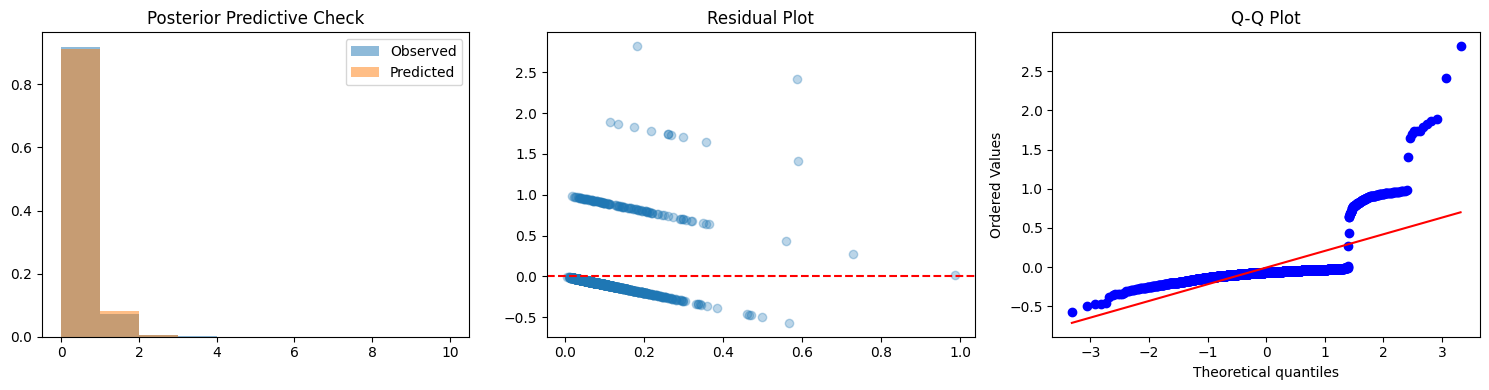

In [67]:
print("\n[5/9] Posterior predictive check...")
post_ppc = posterior_predictive_check(model, idata, train_df, n_samples=500)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Distribution comparison
axes[0].hist(train_df['goals'], bins=range(11), alpha=0.5, label='Observed', density=True)
axes[0].hist(post_ppc['goals_obs'].flatten(), bins=range(11), alpha=0.5, label='Predicted', density=True)
axes[0].legend()
axes[0].set_title('Posterior Predictive Check')

# Residuals
observed = train_df['goals'].values
predicted = post_ppc['goals_obs'].mean(axis=0)
residuals = observed - predicted
axes[1].scatter(predicted, residuals, alpha=0.3)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('Residual Plot')

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.savefig('../../docs/08_posterior_predictive.png', dpi=150, bbox_inches='tight')
plt.show()

## Cell 7: Plot Posterior Distributions

In [68]:
print("\n[6/9] Plotting posteriors...")
plot_posterior(idata, coords, save_path='../../docs/09_goals_posterior.png')
print("  ✓ Saved to docs/09_goals_posterior.png")


[6/9] Plotting posteriors...
  ✓ Saved to docs/09_goals_posterior.png


## Cell 8: Generate Test Predictions

In [69]:
print("\n[7/9] Generating test predictions...")

pred_counts = predict_counts(model, idata, test_df, n_samples=1000)
pred_counts_mean = pred_counts.mean(axis=0)
pred_prob_score = predict_prob_score(pred_counts)
pred_prob_score_mean = pred_prob_score.mean(axis=0)

y_true_counts = test_df['goals'].values
y_true_binary = (y_true_counts > 0).astype(int)

print(f"  Mean predicted goals: {pred_counts_mean.mean():.3f}")
print(f"  Mean observed goals: {y_true_counts.mean():.3f}")

# Uncertainty
pred_ci_lower = np.percentile(pred_counts, 2.5, axis=0)
pred_ci_upper = np.percentile(pred_counts, 97.5, axis=0)
print(f"  Mean CI width: {(pred_ci_upper - pred_ci_lower).mean():.3f}")


[7/9] Generating test predictions...
  Mean predicted goals: 0.067
  Mean observed goals: 0.089
  Mean CI width: 0.855


## Cell 9: Calibration Evaluation

In [70]:
print("\n[8/9] Evaluating calibration...")

calib = evaluate_calibration(y_true_binary, pred_prob_score_mean, n_bins=10)

print(f"\n  ECE: {calib['ece']:.4f} (target: < 0.05)")
print(f"  Brier: {calib['brier']:.4f}")

if calib['ece'] <= 0.05:
    print("  🎉 CALIBRATION GATE PASSED")
else:
    print("  ⚠️  Calibration needs improvement")

plot_calibration_curve(y_true_binary, pred_prob_score_mean, calib['bins_info'],
                       save_path='../../docs/10_goals_calibration_bayesian.png')

# Count metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_true_counts, pred_counts_mean)
rmse = np.sqrt(mean_squared_error(y_true_counts, pred_counts_mean))
print(f"\n  MAE: {mae:.3f} goals")
print(f"  RMSE: {rmse:.3f} goals")


[8/9] Evaluating calibration...

  ECE: 0.0296 (target: < 0.05)
  Brier: 0.0797
  🎉 CALIBRATION GATE PASSED

  MAE: 0.140 goals
  RMSE: 0.282 goals


## Cell 10: Save Model Artifacts

In [71]:
print("\n[9/9] Saving model...")

metadata = {
    'version': '1.0',
    'date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'model_type': 'Hierarchical Poisson Regression',
    'sampling_method': sampling_method,
    'n_train': len(train_df),
    'n_test': len(test_df),
    'ece': float(calib['ece']),
    'brier': float(calib['brier']),
    'mae': float(mae),
    'rmse': float(rmse),
    'convergence': {
        'max_rhat': float(conv['max_rhat']),
        'min_ess': int(conv['min_ess']),
        'n_divergences': int(conv['n_divergences'])
    },
    'features': ['goals_rolling_5', 'shots_on_target_rolling_5', 
                 'opponent_strength', 'days_since_last_match', 'was_home'],
    'positions': list(coords['position'])
}

save_model(
    idata, metadata,
    model_path='../../models/bayesian_goals_v1.0.pkl',
    trace_path='../../models/bayesian_goals_v1.0_trace.nc'
)



[9/9] Saving model...
✓ Saved trace to /Users/medhanshchoubey/player-prop-gnn-1/player-prop-gnn/models/bayesian_goals_v1.0_trace.nc
✓ Saved metadata to /Users/medhanshchoubey/player-prop-gnn-1/player-prop-gnn/models/bayesian_goals_v1.0.pkl
